In [1]:
# import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# from pylab import rcParams
# rcParams['figure.figsize'] = 10, 8
# rcParams['figure.dpi'] = 300

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda:0')
# torch.set_default_dtype(torch.float64)

# change it to cpu if there's no cuda device
# device = torch.device('cpu')

In [2]:
import numpy as np

In [3]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask):
        super(RealNVP, self).__init__()
        
        self.mask = nn.Parameter(mask, requires_grad=False).to(device)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        
    def f(self, z):
        x = z
        log_det_J = z.new_zeros(z.shape[0])
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
            log_det_J += s.sum(dim=1)
        return x, log_det_J

    def f_inv(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J

In [4]:
n,p = int(200),1000

X = torch.randn(n,p).to(device)

d = 5


w0 = torch.from_numpy(np.array([(np.random.normal(1,0.1,[d])).tolist() +[0]*(p-d)]).astype(np.float32)).t().to(device)


psi = (X@w0)[:,0]


y = psi + torch.rand(n).to(device) * 1

In [5]:
total_param = p + 4 # needs to be even


latent_dim = 256

mask1 = [0,1]* int(total_param/2)
mask2 = [1- x for x in mask1]

nets = lambda: nn.Sequential(nn.Linear(total_param, latent_dim), nn.LeakyReLU(), nn.Linear(latent_dim, latent_dim), nn.LeakyReLU(), nn.Linear(latent_dim, total_param), nn.Tanh()).to(device)
nett = lambda: nn.Sequential(nn.Linear(total_param, latent_dim), nn.LeakyReLU(), nn.Linear(latent_dim, latent_dim), nn.LeakyReLU(), nn.Linear(latent_dim, total_param)).to(device)
masks = torch.from_numpy(np.array([mask1, mask2] * 2).astype(np.float32)).to(device)


K = 3 # when K is 1, it's equivalent to normalizing flow

flow_list = [RealNVP(nets, nett, masks) for _ in range(K)]

net_pi = lambda: nn.Sequential(nn.Linear(total_param, latent_dim), nn.LeakyReLU(), nn.Linear(latent_dim, latent_dim), 
                               nn.LeakyReLU(), nn.Linear(latent_dim, K), nn.Softmax(dim=1)).to(device)

flow_pi = net_pi()

In [6]:
batch_size = 300

In [7]:
beta = torch.rand([batch_size, total_param]).to(device)

In [8]:
beta.shape

torch.Size([300, 1004])

In [9]:
def f_(w, r):
    idx = 0
    idx1 = idx + p
    abs_w = torch.abs(w).to(device)
    sorted_w, argsort_w = abs_w.sort(descending = True)

#     mu = torch.zeros(p, batch_size).to(device)
#     K_ = torch.zeros(p, batch_size).to(device)
#     for i in range(p):
#         mu[i] = sorted_w[:,0:i+1].sum(dim = 1)-r
#         K_[i] = sorted_w[:,i] > mu[i]/(i+1)
#     K_ = K_.sum(dim = 0).type(torch.int64)

    mu = sorted_w.cumsum(dim=1).T -r
    seq = torch.arange(start=1,end=p+1,step=1).to(device)
    K_ = sorted_w > (mu.T/ seq)
    K_ = K_.sum(dim = 1).type(torch.int64) 

#     mu_k = torch.zeros(batch_size).to(device)
#     scaled_mu_k = torch.zeros([batch_size,1]).to(device)
#     for j in range(batch_size):
#         scaled_mu_k[j,0] = mu[K_[j], j]/(K_[j] + 1)

    scaled_mu_k= (mu[K_,:].diag()/(K_+1)).reshape([batch_size,1])

    s = torch.sign(w).to(device)
    
    t = abs_w-torch.repeat_interleave(scaled_mu_k, p, dim=1)
    eta = s.t()*torch.max(t.t(), torch.zeros(p,batch_size).to(device))
    return [eta, scaled_mu_k]

In [10]:
def loglik(theta):
    idx = 0
    idx1 = idx + p
    w = theta[:,idx: idx1]
    
    idx = idx1
    idx1 = idx + 1
    r = torch.nn.functional.softplus(theta[:,idx:idx1].flatten())
    
    idx = idx1
    idx1 = idx + 1
    lam = torch.nn.functional.softplus(theta[:,idx:idx1].flatten())
    
    idx = idx1
    idx1 = idx + 1
    sigma2 = torch.nn.functional.softplus(theta[:,idx:idx1].flatten())
    
    prior_w = - w.abs().sum(1)/lam -  p* torch.log(lam)
    
    
    lam_a = 1
    lam_b = 1E-2 # small lam_b to force most of lam to be close to zero
    prior_lam = - (lam_a+1) * torch.log(lam)  - lam_b/lam

    
    prior_sigma2 =  - torch.log(sigma2)
    
    n = y.shape[0]
    
    eta, mu_c = f_(w, r)
    
    
    # quantile
    mu_c_q =  torch.exp( - torch.log(mu_c/lam_b + 1) * lam_a)
    # prior for r, equivalent to  mu_c_q~ Beta(1,b_w), prior mean 1/(1+b_w)
    
    b_w = 9 # prior belief: the expected threshold is the 10% quantile of lambda
    prior_r  =  (b_w-1) * torch.log(1.0- mu_c_q).flatten()
    
    
    psi = (eta.t())@X.t()
    lik =  -((y - psi)**2).sum(1)/2.0 /sigma2 - n*torch.log(sigma2) /2.0
    
    total_posterior= lik + prior_w + prior_lam + prior_r + prior_sigma2
    
    return total_posterior

In [11]:
def log_reference(z):
    #     Using Uniform 
    return  0

In [12]:
para_list = list()

In [13]:
for flow in flow_list:
    para_list+= list(flow.parameters())
    
para_list +=  list(flow_pi.parameters())

In [14]:
from torch.distributions import gumbel

In [15]:
gum_rng= gumbel.Gumbel(0,1)


def soft_multinomial(Pi):
    lam = 0.1
    return torch.softmax((Pi.log() + gum_rng.sample(Pi.shape).to(device))/lam,1)


def soft_multinomial_log(logPi):
    lam = 0.1
    return torch.softmax((logPi + gum_rng.sample(logPi.shape).to(device))/lam,1)

In [16]:
import copy


best_loss = np.inf

In [17]:
best_model= copy.deepcopy([flow_list , flow_pi])

In [18]:
optimizer = torch.optim.Adam([p for p in para_list if p.requires_grad==True], lr=1e-4)

In [19]:
def genBeta(batch_size): 
    
    return torch.rand([batch_size, total_param]).to(device)

In [20]:
for t in range(2000):
    
    beta =  genBeta(batch_size)
    
    Loglik_list = list()
    z_list = list()
    
    for k in range(K):

        flow = flow_list[k]
        z_cad, logdetJ = flow.f(beta)
        Loglik_list.append(loglik(z_cad)+logdetJ + torch.log(flow_pi(z_cad)[:,k]))
#         z_list.append(z_cad) 
        
    g = - torch.logsumexp(torch.stack(Loglik_list), dim=0) + log_reference(beta)
        
    loss =    g.mean() 
    
    if (t+1)%100==0:
        print(t, loss.item())
    
    if loss.item()< best_loss:
        best_model= copy.deepcopy([flow_list , flow_pi])
        best_loss = loss.item()
        
    if np.isnan(loss.cpu().data.numpy()):    
        flow_list,flow_pi = best_model
          
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

99 -214.45999145507812
199 -364.60308837890625
299 -371.0802307128906
399 -374.3169250488281
499 -375.2684326171875
599 -376.33819580078125
699 -375.3802185058594
799 -377.5168762207031
899 -376.80096435546875
999 -379.8304443359375
1099 -379.1796875
1199 -378.29498291015625
1299 -380.8114013671875
1399 -379.1718444824219
1499 -379.83319091796875
1599 -378.7735290527344
1699 -380.99224853515625
1799 -382.4259033203125
1899 -380.8150634765625
1999 -381.33404541015625


In [21]:
[flow_list , flow_pi] = best_model

beta =  genBeta(batch_size)

Loglik_list = list()
z_list = list()

for k in range(K):

    flow = flow_list[k]
    z_cad, logdetJ = flow.f(beta)
    Loglik_list.append(loglik(z_cad)+logdetJ + torch.log(flow_pi(z_cad)[:,k]))
    z_list.append(z_cad) 

g = - torch.logsumexp(torch.stack(Loglik_list), dim=0) + log_reference(beta)

loss =    g.mean() 


c = soft_multinomial_log(torch.stack(Loglik_list).t())
z_candidates = torch.stack(z_list)

z = torch.stack( [c[i]@ z_candidates[:,i,:] for i in range(beta.shape[0])])


In [22]:
w = z[:,0:p]
r = torch.nn.functional.softplus(z[:,p])
w_post,_ = f_(w,r)

w_post = w_post.T.cpu().detach().numpy()

In [23]:
# (w_post[np.logical_not(np.isnan(w_post[:,0]))]).mean(axis=0)[:d+5]

In [24]:
import seaborn as sns
import pandas as pd

In [25]:
w5 = pd.DataFrame( {'Value': w_post[:,:10].flatten(order='F'), 
                    'w': np.repeat(np.arange(1,11),w_post.shape[0]),
                    'Method': "Transport"
                   })

In [26]:
w5_2 = pd.DataFrame( {'Value': np.repeat(w0.cpu().numpy()[:10],w_post.shape[0]) + 
                      np.random.randn(w_post.shape[0]*10)*0.001, 
                    'w': np.repeat(np.arange(1,11),w_post.shape[0]),
                    'Method': "Oracle"
                   })

In [27]:
w_long = pd.concat([w5, w5_2])

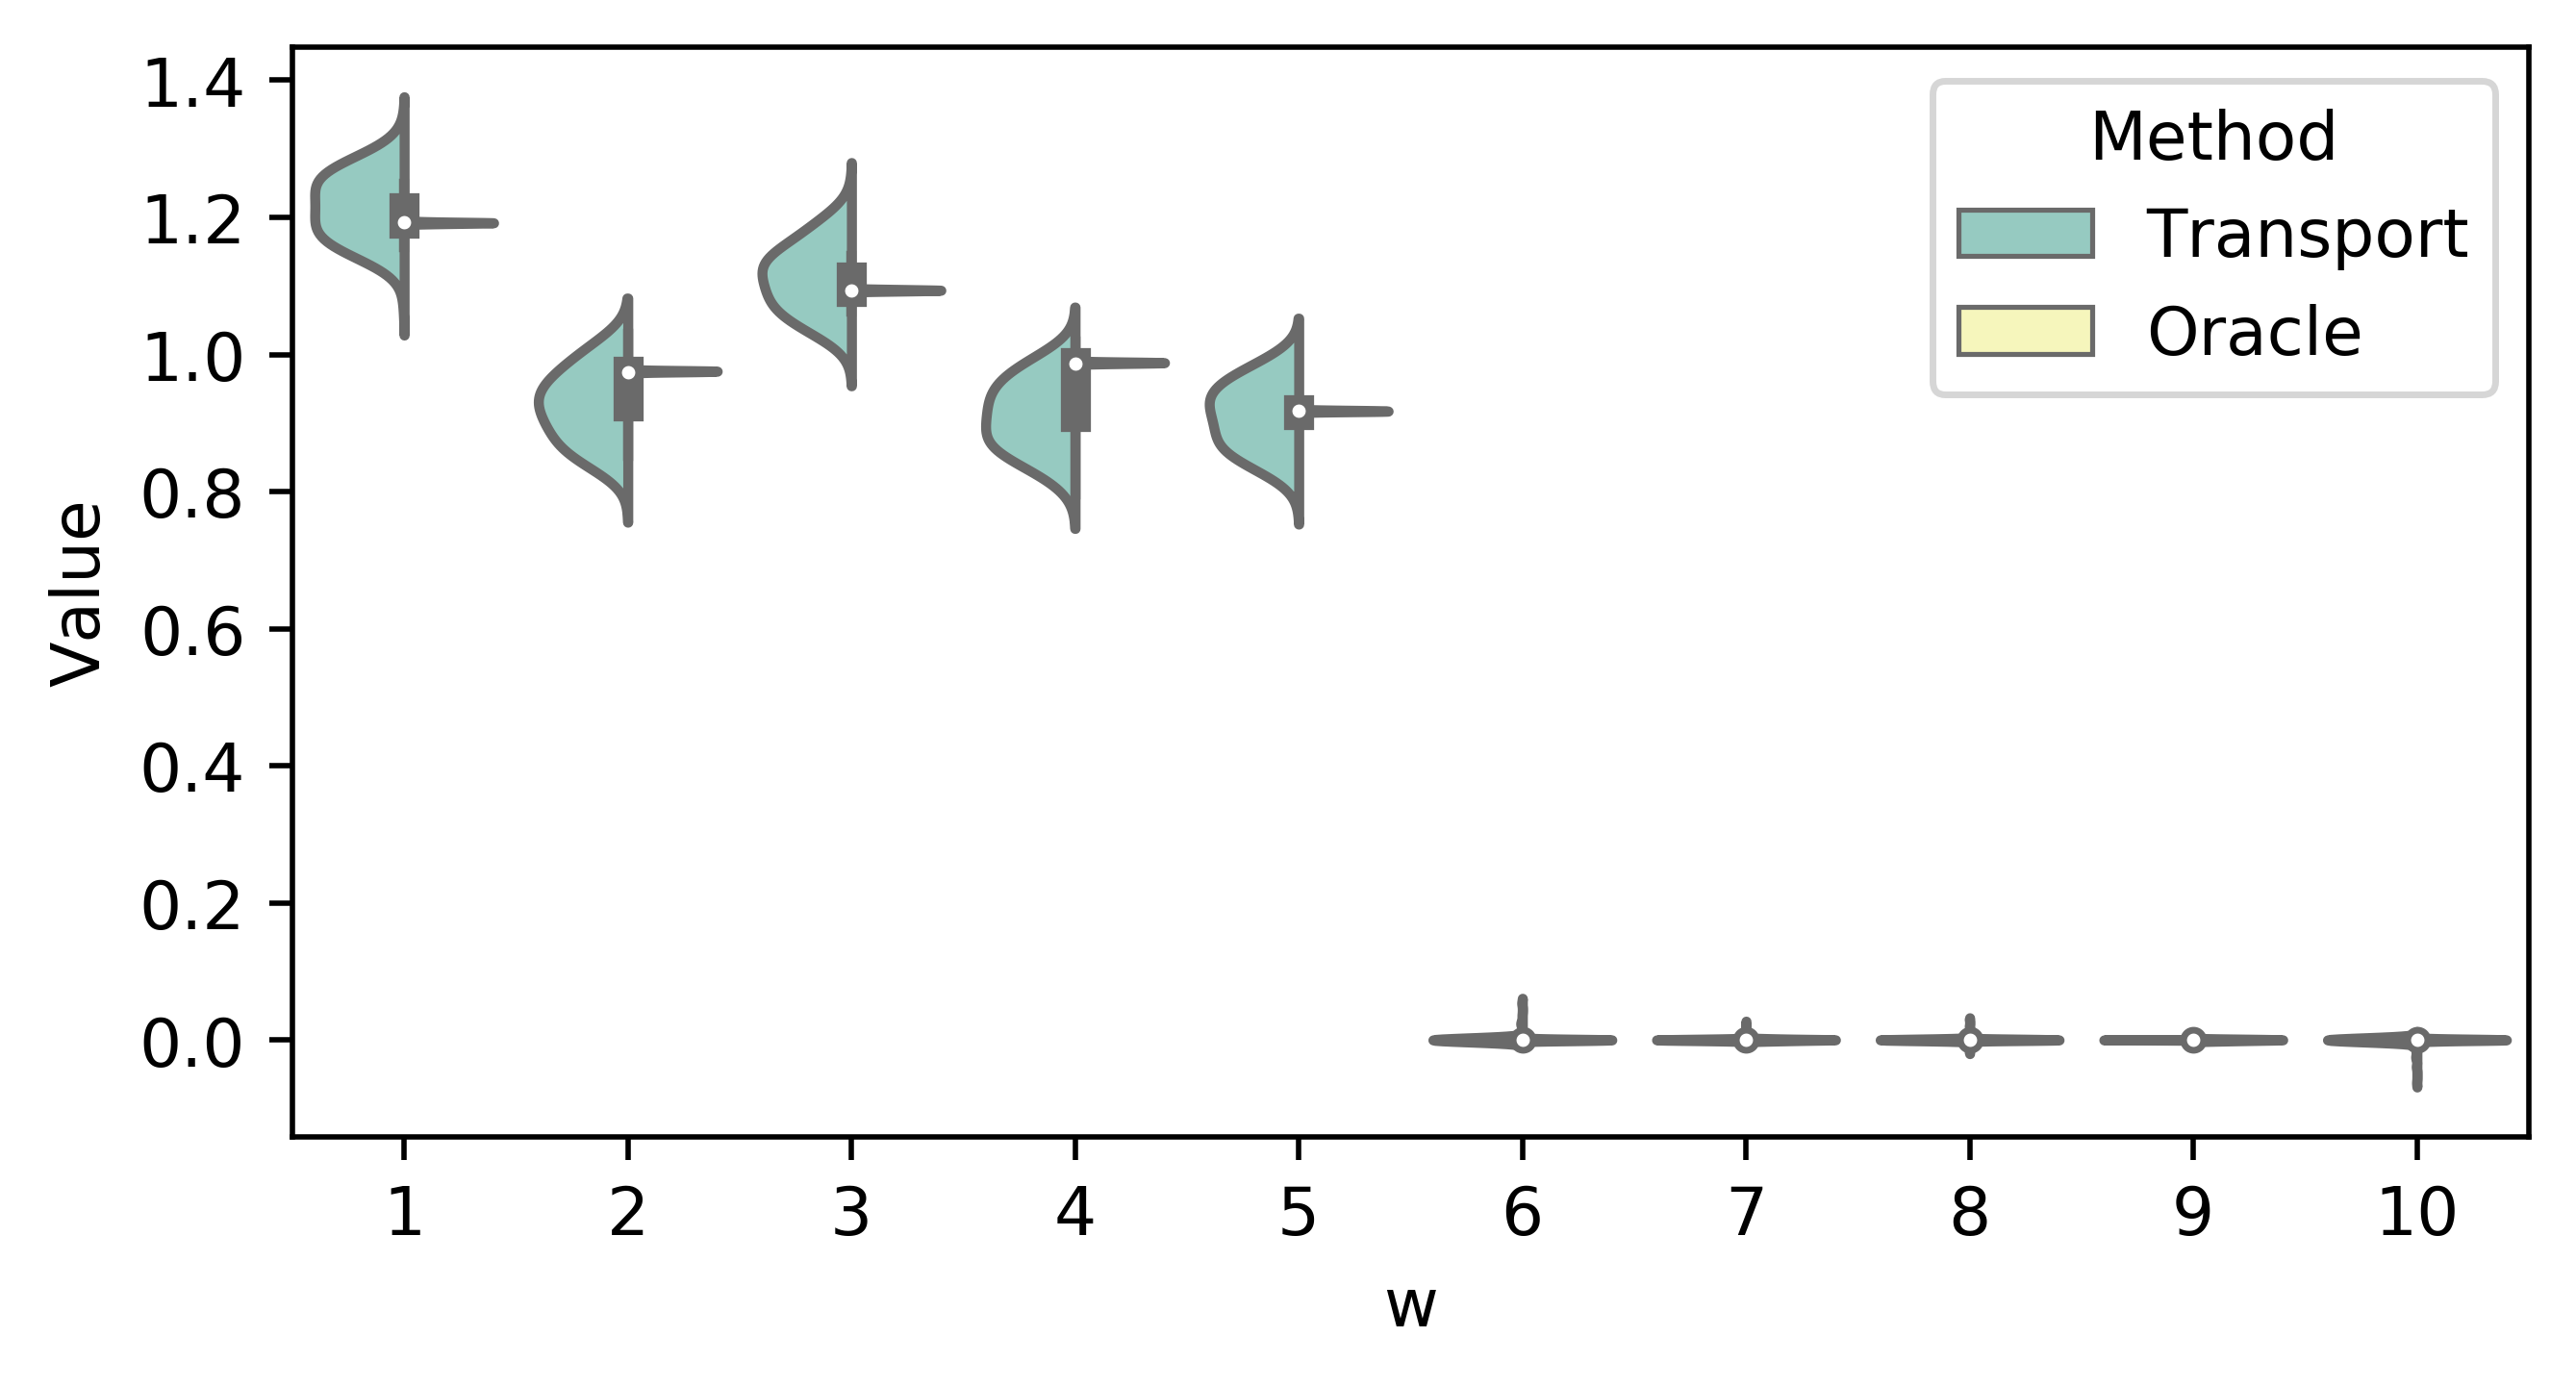

In [28]:
fig = plt.figure(figsize=(6, 3), dpi=200 )       # size in inches

ax = sns.violinplot(x="w", y="Value",data=w_long, hue="Method",
                    palette="Set3",
                    split=True,    scale="count", bw=0.5)


Text(0.5, 0, 'batch')

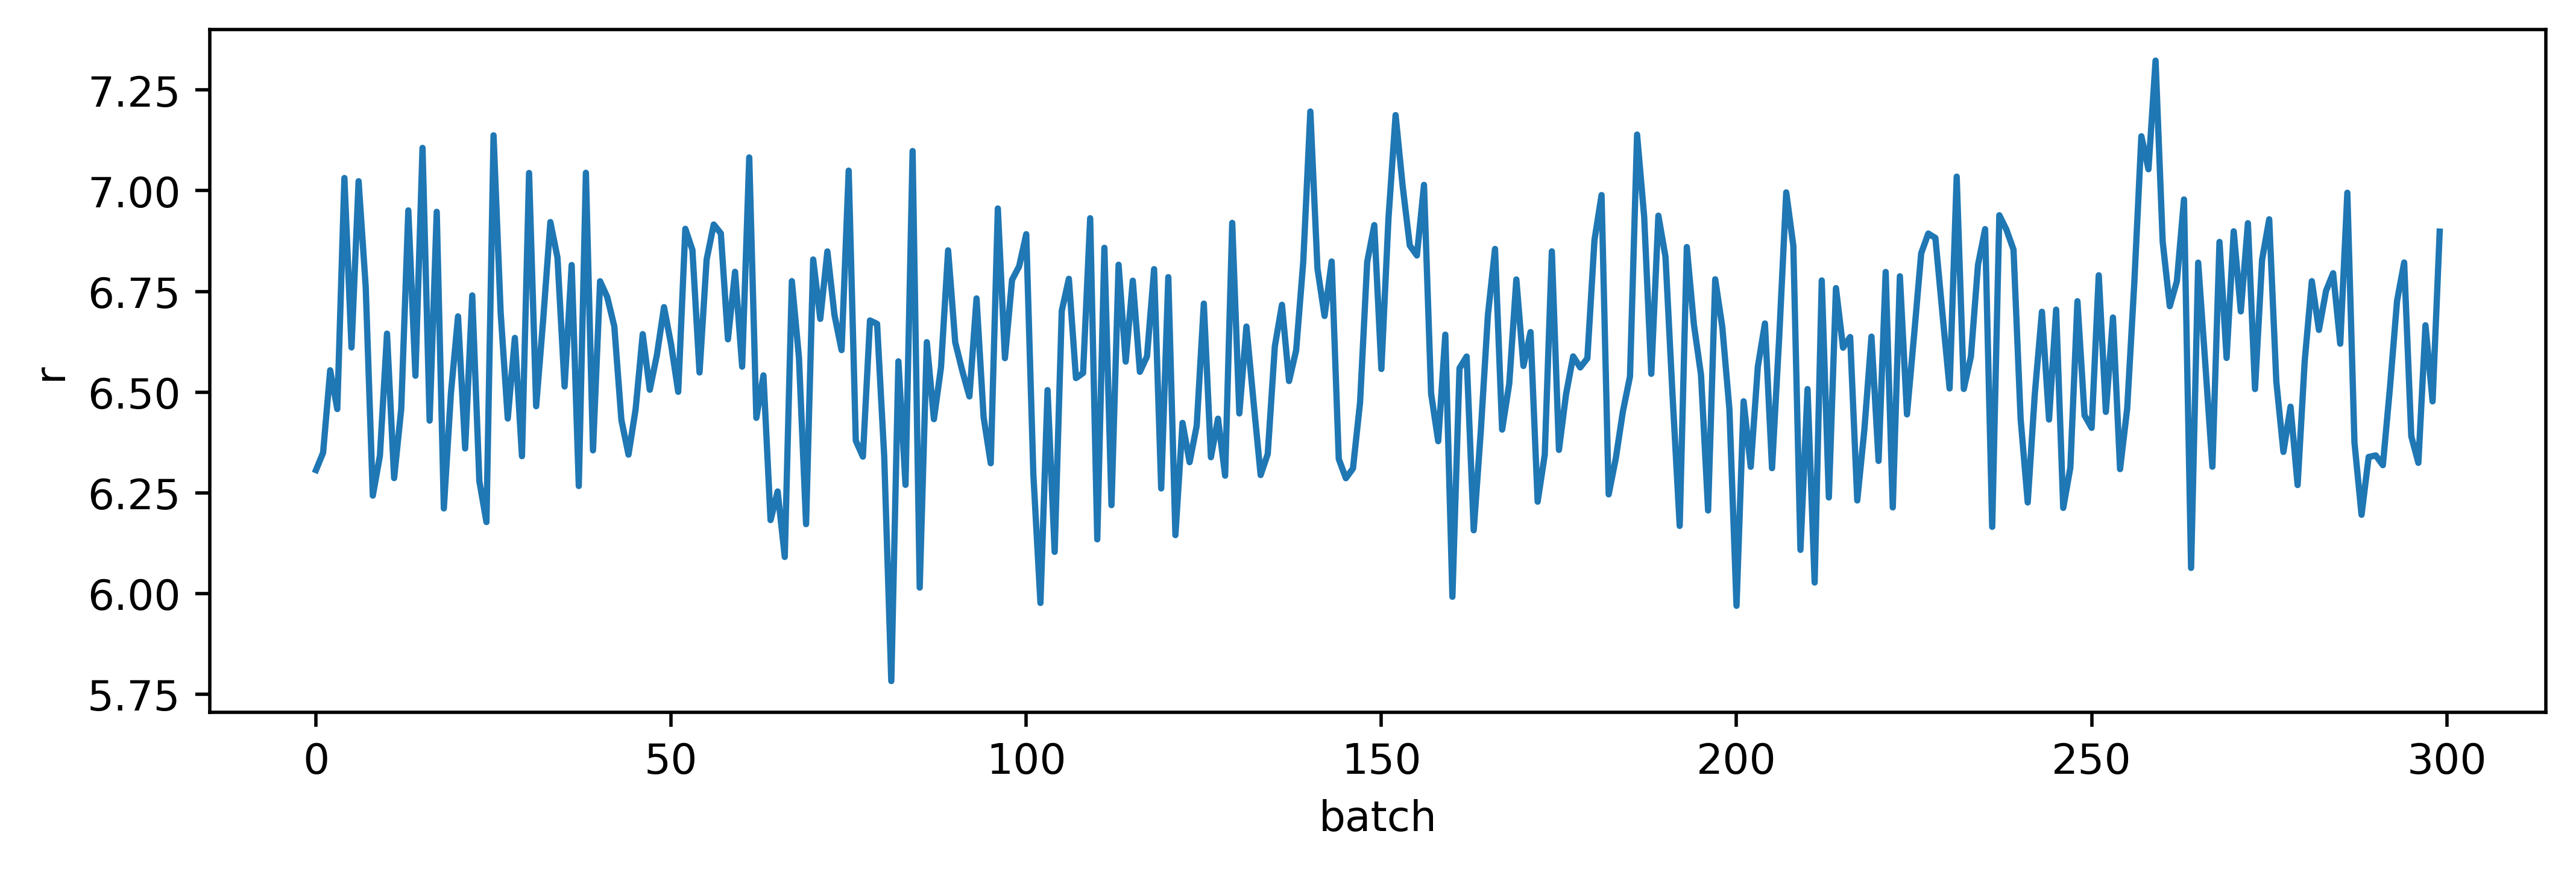

In [29]:
fig = plt.figure(figsize=(10, 3), dpi=200 )    
plt.plot(r.cpu().detach().numpy())
plt.ylabel("r")
plt.xlabel("batch")

/home/shared/anaconda3/envs/leo/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


Text(0.5, 1.0, 'Auto-correlation of Posterior Sample')

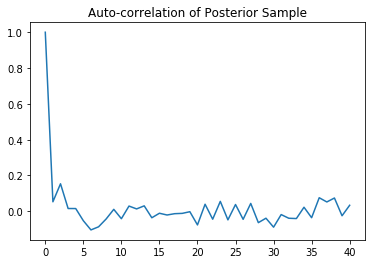

In [30]:
from statsmodels.tsa.stattools import acf
plt.plot(acf(r.cpu().detach().numpy()))
plt.title("Auto-correlation of Posterior Sample")

Text(0.5, 0, 'batch')

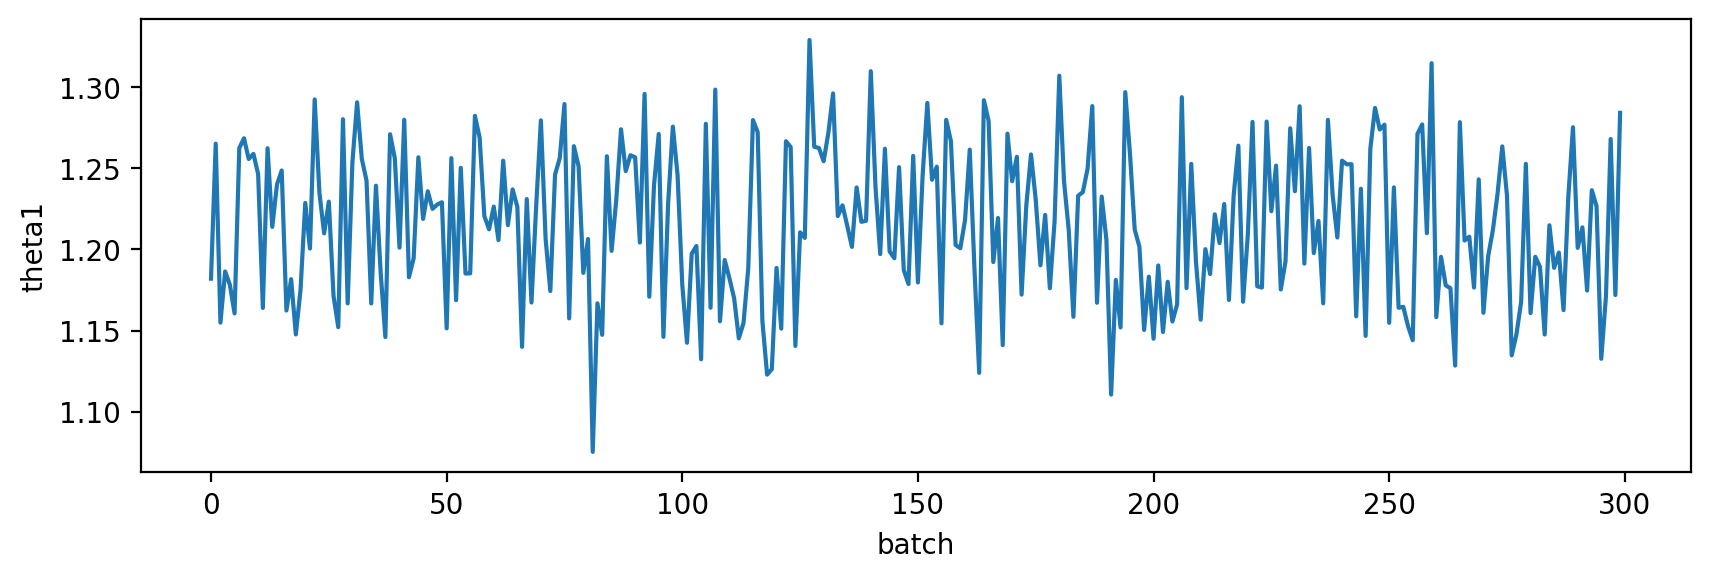

In [31]:
fig = plt.figure(figsize=(10, 3), dpi=200 )    
plt.plot(w_post[:,0])
plt.ylabel("theta1")
plt.xlabel("batch")

Text(0.5, 1.0, 'Auto-correlation of Posterior Sample')

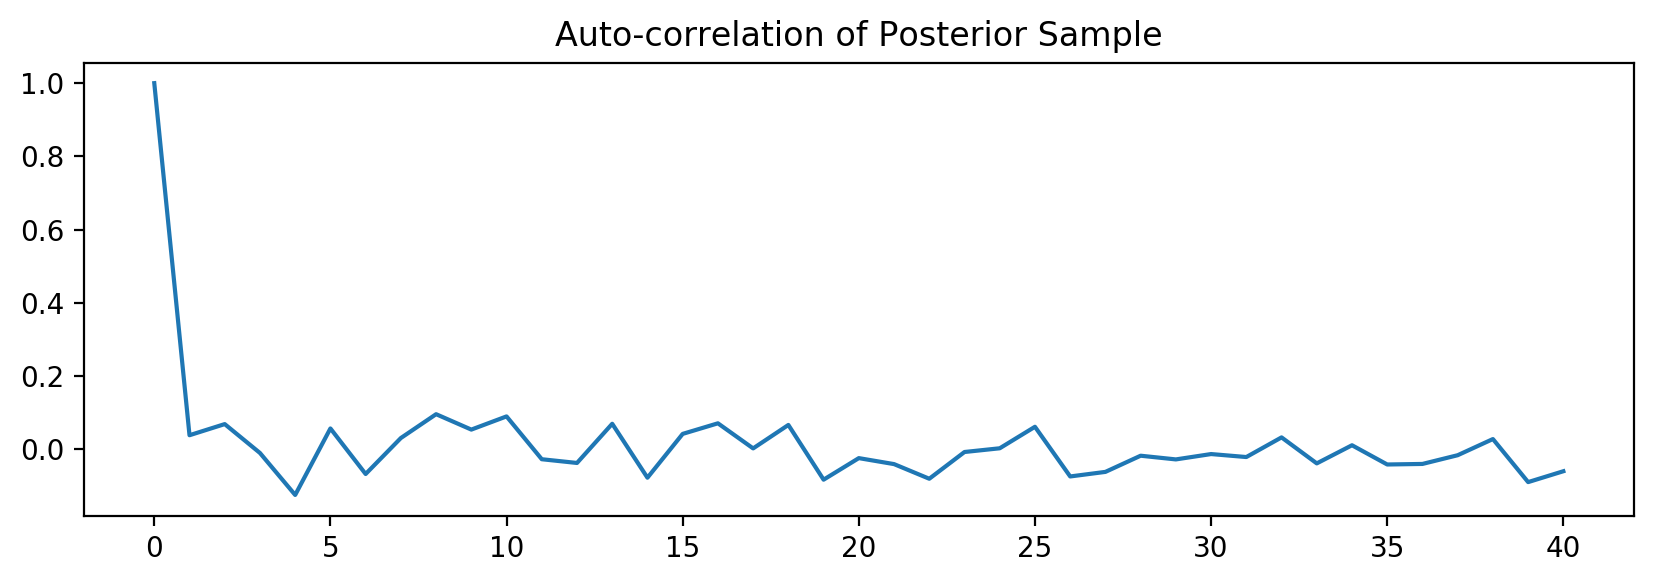

In [32]:
fig = plt.figure(figsize=(10, 3), dpi=200 )    

plt.plot(acf(w_post[:,0]))
plt.title("Auto-correlation of Posterior Sample")

Text(0.5, 0, 'batch')

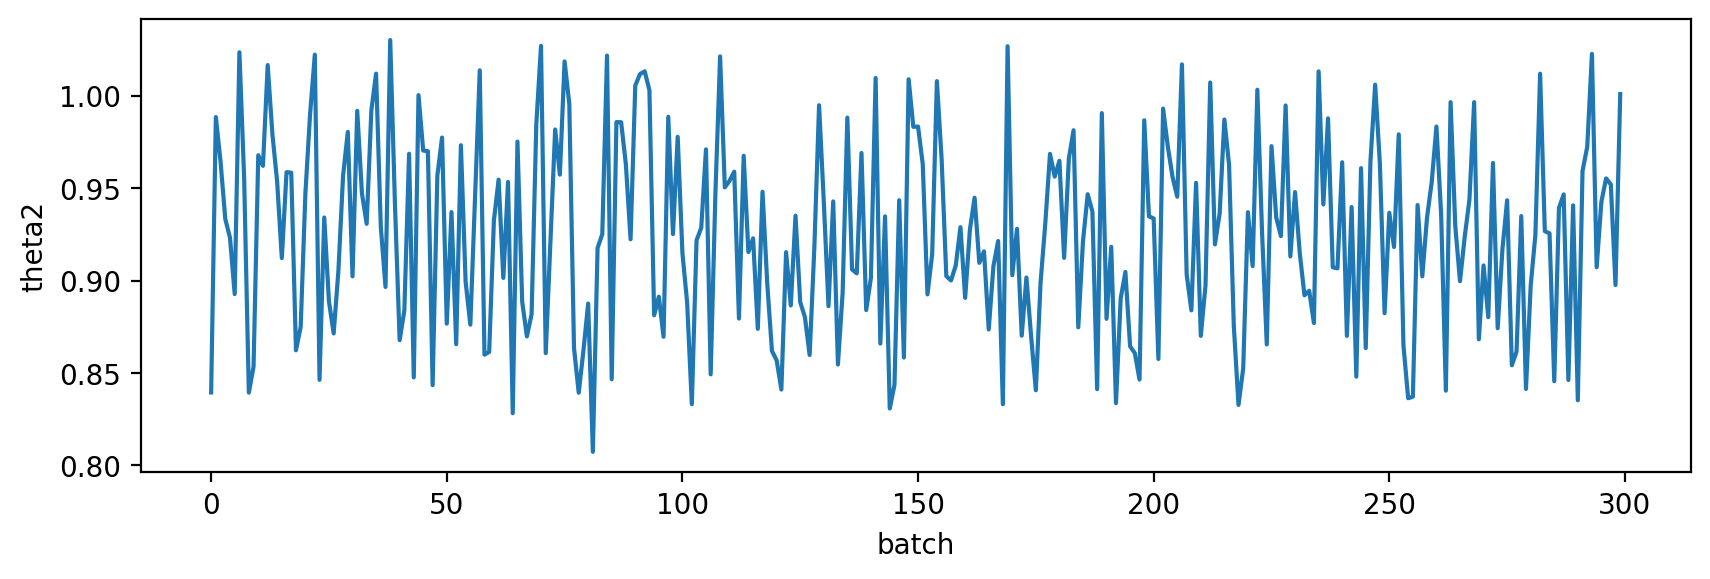

In [33]:
fig = plt.figure(figsize=(10, 3), dpi=200 )    
plt.plot(w_post[:,1])
plt.ylabel("theta2")
plt.xlabel("batch")

Text(0.5, 1.0, 'Auto-correlation of Posterior Sample')

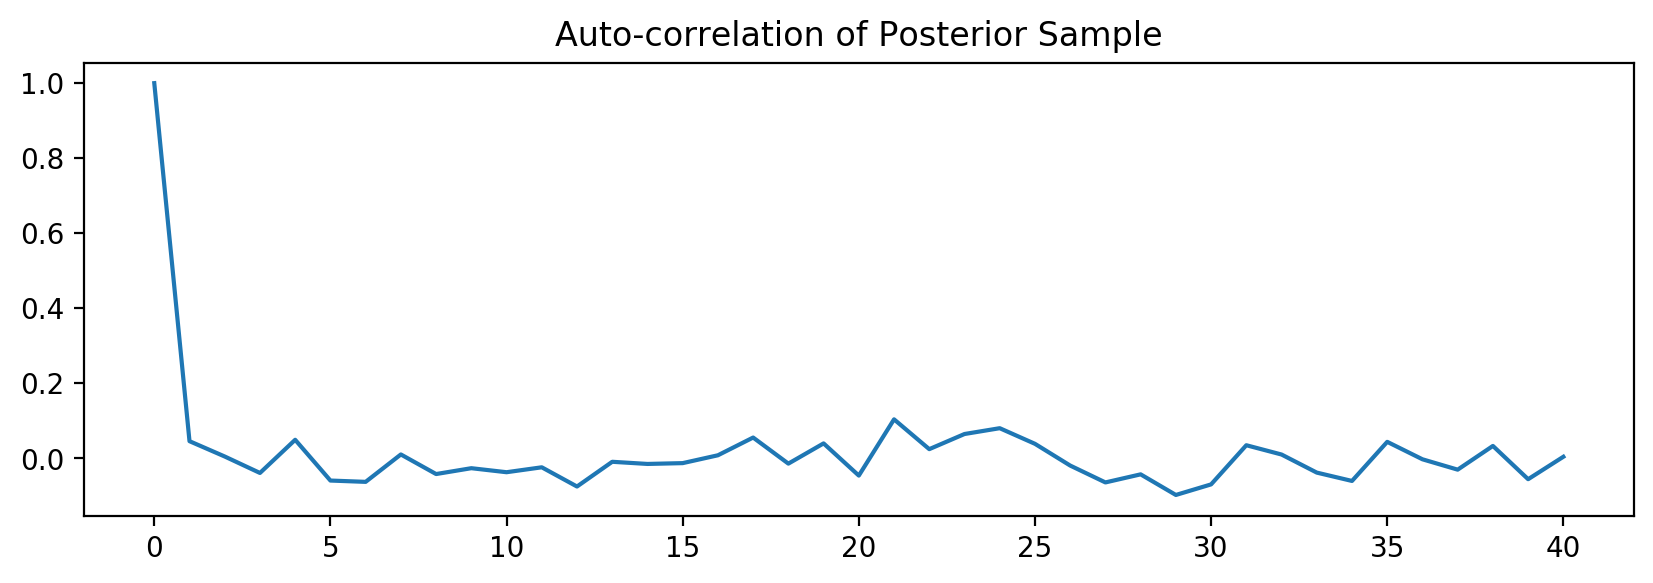

In [34]:
fig = plt.figure(figsize=(10, 3), dpi=200 )    

plt.plot(acf(w_post[:,1]))
plt.title("Auto-correlation of Posterior Sample")